# Zestawienie metod redukcji wymiaru i ich efektywności
- na przykładzie zbioru iris

In [1]:
import numpy as np
import pandas as pd
from sklearn import decomposition
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import t_sne
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import FeatureAgglomeration
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import minmax_scale
import random
from sklearn import datasets
np.set_printoptions(precision=3)

Using TensorFlow backend.


In [2]:
iris = datasets.load_iris()
iris_X = iris.data

Budowa autoenkodera

In [3]:
def autoenkoder(iris_X):
    scaled_X = minmax_scale(iris_X, axis = 0)

    model = Sequential()
    model.add(Dense(4, input_shape = (scaled_X.shape[1],)))
    model.add(Dense(2, activation = 'sigmoid'))
    model.add(Dense(scaled_X.shape[1], activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    model.fit(scaled_X, scaled_X,
              batch_size = 4,
              epochs = 50,
              validation_split = 0.25,
              verbose = False)
    iris_X_nn = model.predict(scaled_X.reshape(-1, scaled_X.shape[1]))

    # wybór kolumn z największą wariancją
    max_var_ind_1 = np.argmax(iris_X_nn.std(0))
    iris_X_nn_2 = np.delete(iris_X_nn, max_var_ind_1, 1)
    max_var_ind_2 = np.argmax(iris_X_nn_2.std(0))
    col_1 = iris_X_nn[:, max_var_ind_1]
    col_2 = iris_X_nn_2[:, max_var_ind_2]
    iris_X_red = np.column_stack((col_1, col_2))
    return iris_X_red

Funkcja wyliczająca proporcje sumy wariancji wewnątrz poszczególnych klastrów do wariancji dla całej populacji 
- Wskaźnik użyty jako kryterium zawartości informacji o wewnętrznej strukturze zbioru

In [4]:
def var_clusters_ratio(iris_X):
    X_scaled = MinMaxScaler().fit_transform(iris_X)
    v0 = pd.DataFrame(X_scaled, iris.target).loc[0].var(0).sum()
    v1 = pd.DataFrame(X_scaled, iris.target).loc[1].var(0).sum()
    v2 = pd.DataFrame(X_scaled, iris.target).loc[2].var(0).sum()
    return round(float((v0+v1+v2)/X_scaled.var(0).sum()), 3)

Zestawienie porównywanych metod redukcji wymiaru
- Pierwszy wykres metody Select KBest prezentuje rzut dwóch wymiarów zbioru bazowego o największej wariancji, bez stosowania redukcji wymiarów

In [5]:
n_components = 2
dim_reductors = [
     ('Select KBest chi2',
     SelectKBest(chi2, k=n_components)),
     ('Principal Component Analysis',
     decomposition.PCA(n_components=n_components, svd_solver='randomized')),
     ('Incremental PCA',
     decomposition.IncrementalPCA(n_components=n_components)),
     ('Sparse PCA',
     decomposition.SparsePCA(n_components=n_components)),
     ('Mini Batch Sparse PCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3)),
     ('Kernel PCA cosine',
     decomposition.KernelPCA(kernel='cosine', n_components=n_components)),
     ('Kernel PCA rbf',
     decomposition.KernelPCA(kernel='rbf', n_components=n_components)),
     #kernels: poly rbf sigmoid cosine precomputed')
     ('Truncated SVD',
     decomposition.TruncatedSVD(n_components=n_components)),
     ('Linear Discriminant Analysis - LDA',
     LinearDiscriminantAnalysis(n_components=n_components)),
     ('Factor Analysis Components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2)),
     ('Non-negative Components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3)),
     ('Independent Components - Fast ICA',
     decomposition.FastICA(n_components=n_components, whiten=True)),
     ('Sparse Random Projection',
     SparseRandomProjection(n_components=2)),
     ('Feature Agglomeration',
     FeatureAgglomeration(linkage='ward', affinity='euclidean', n_clusters=2)),
     ('Gaussian Random Projection',
     GaussianRandomProjection(n_components=2)),
     ('Cluster Centers - Mini Batch KMeans',
     MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50)),
     ('t-Distrib. Stochastic Neighbor Embedding',
     t_sne.TSNE(n_components=n_components, n_iter=5000)),
     ('Dictionary Learning',
     decomposition.DictionaryLearning(3)),
     ('Latent Dirichlet Allocation',
     decomposition.LatentDirichletAllocation(n_components=n_components)),
     ('Autoencoder NN', np.nan) ]

Przygotowanie wykresów rozproszenia po redukcji wymiaru
- Obliczenie proporcji zestandaryzowanej wariancji po i przed redukcją wymiarów
- Variation ratio = suma wariancji zestandaryzowanych wymiarów po zastosowaniu redukcji wymiarów : suma wariancji zestandaryzowanych wymiarów zbioru bazowego
- Wskaźnik określa ilość informacji zachowanej po redukcji wymiarów względem zbioru bazowego

/home/sas/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)
/home/sas/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


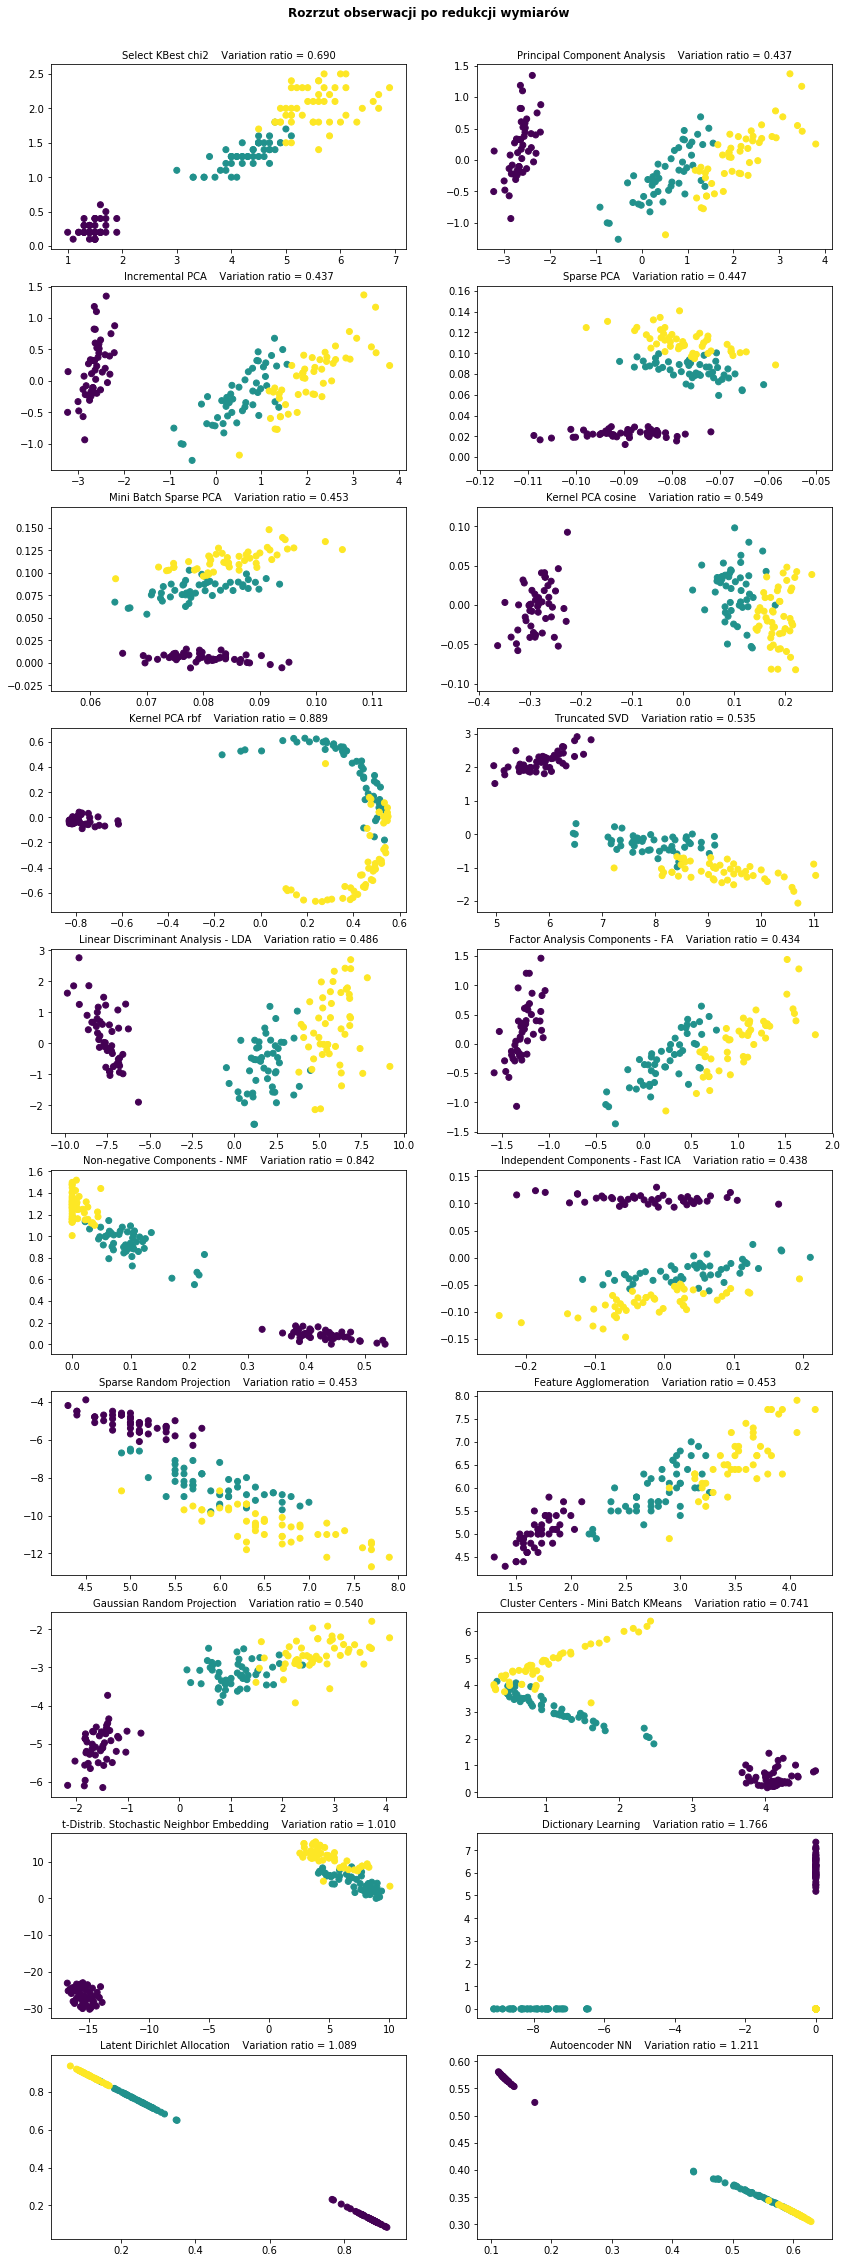

In [38]:
var_base = MinMaxScaler().fit_transform(iris_X).var(0).sum()
i = 0; j = 0; names_all = []; var_clusters_ratios = [];
f, axs = plt.subplots(nrows=round(len(dim_reductors)/2+0.1), ncols=2, figsize=(14, round(len(dim_reductors)/2+0.1)*4))
f.suptitle('Rozrzut obserwacji po redukcji wymiarów', y=0.9, fontsize=12, fontweight='bold')
for name, estimator in dim_reductors:
    if name.startswith('Select KBest') or name.startswith('Linear'):
        iris_X_red = estimator.fit_transform(iris_X, iris.target)
    elif name.startswith('Autoencoder'):
        iris_X_red = autoenkoder(iris_X)
    else:
        iris_X_red = estimator.fit_transform(iris_X)
    var_ratio = MinMaxScaler().fit_transform(iris_X_red).var(0).sum()/var_base
    names_all.append(name)
    var_clusters_ratios.append(var_clusters_ratio(iris_X_red))
    axs[i][j].scatter(iris_X_red[:, 0], iris_X_red[:, 1] , c=iris.target)
    axs[i][j].set_title(name + '    Variation ratio = {:5.3f}'.format(var_ratio), fontsize=10)
    if j == 0: j = 1
    else: j = 0; i += 1
plt.show()

Generowanie losowych kolorów do wykresu

In [45]:
colors = np.vectorize(lambda x: random.random())(np.zeros([len(names_all)+1, 3]))

Graficzne zestawienie wariancji
- Proporcje zestandaryzowanej (min-max) wariancji wewnątrz poszczególnych klastrów do wariancji ogółem
- Wskaźnik użyty jako kryterium zawartości informacji o strukturze zbioru po redukcji wymiarów
- Dodany wskaźnik dla zbioru bazowego jako benchmark

In [40]:
var_clusters_ratios.append(var_clusters_ratio(iris_X))
names_all.append('ZBIÓR BAZOWY (wariancja z 4 wymiarów)')

In [41]:
df = pd.DataFrame(var_clusters_ratios, names_all)
df_sorted = df.sort_values(0, ascending=False)

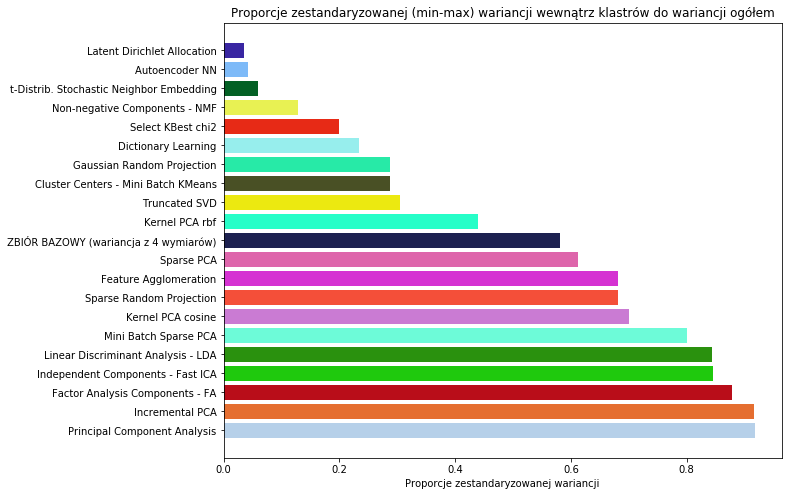

In [46]:
f = plt.figure(figsize=(10, 8))
ax = f.add_subplot(111)
ax.barh(df_sorted.index, df_sorted.values[:,0],  align='center',
        color=colors, ecolor='black')
ax.set_yticks(names_all)
ax.set_xlabel('Proporcje zestandaryzowanej wariancji')
ax.set_title('Proporcje zestandaryzowanej (min-max) wariancji wewnątrz klastrów do wariancji ogółem')
plt.show()

- Im metoda znajduje się niżej na wykresie, tym więcej informacji o strukturze redukowanego zbioru (proporcji wariancji) zostało zachowane po redukcji wymiarów
- Jak można było oczekiwać, Autoenkoder wyczyścił dane z komponent, które uznał za "szumy" - stąd niski wskaźnik wariancji wewnątrz klastrów do wariancji ogółem
- Algorytmy zawierające element losowości, jak np. Sparse Random Projection w niektórych uruchomieniach uzyskały wskaźnik powyżej jedności, co oznacza dodanie "szumu" do zredukowanych wymiarów,
- Metody umiejscowione wyżej na wykresie przydatne są bardziej do klasyfikacji niż do redukcji wymiarów, dość mocno minimalizują wariancję wewnątrz klastrów, tj. ściśle grupują podobne obserwacje w grupach o małym rozproszeniu, jednocześnie mogą zwiększać wariancję ogółem zbioru po redukcji wymiarów względem wariancji próby bazowej
- Im metoda niżej na wykresie, tym więcej zachowuje informacji o strukturze zbioru po redukcji wymiarów